<a href="https://colab.research.google.com/github/defnethecoder/DSA210-PROJECT/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", 200)
plt.rcParams["figure.figsize"] = (12, 6)

print("Setup complete. Libraries loaded.")

In [4]:
ELECTION_PATH = "Election.csv"
WUI_PATH      = "WUIEUROPE (3).csv"     # <-- ONLY CHANGE (new WUI file)
MIG_PATH      = "migrationData.csv"

election_raw = pd.read_csv(ELECTION_PATH)
wui_raw      = pd.read_csv(WUI_PATH)                  # <-- ONLY CHANGE (read_csv instead of read_excel)
mig_raw      = pd.read_csv(MIG_PATH)

print("Election:", election_raw.shape)
print("WUI:", wui_raw.shape)
print("Migration:", mig_raw.shape)

display(election_raw.head())
display(wui_raw.head())
display(mig_raw.head())

Election: (9006, 24)
WUI: (12, 2)
Migration: (1442, 19)


,country_name_short,country_name,election_type,election_date,vote_share,seats,seats_total,party_name_short,party_name,party_name_english,left_right,country_id,election_id,previous_parliament_election_id,previous_cabinet_id,party_id,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23
0,AUS,Australia,parliament,1901-03-30,44.4,32.0,75,PP,Protectionist Party,Protectionist Party,7.4,33,731.0,NaN,NaN,1898,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AUS,Australia,parliament,1901-03-30,34.2,26.0,75,FTP,Free Trade Party,Free Trade Party,6,33,731.0,NaN,NaN,1938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AUS,Australia,parliament,1901-03-30,19.4,15.0,75,ALP,Australian Labor Party,Australian Labor Party,3.8833,33,731.0,NaN,NaN,1253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AUS,Australia,parliament,1901-03-30,1.4,1.0,75,none,no party affiliation,no party affiliation,NaN,33,731.0,NaN,NaN,1396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AUS,Australia,parliament,1901-03-30,0.6,1.0,75,one-seat,one seat,one seat,NaN,33,731.0,NaN,NaN,2299,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,observation_date,WUIEUROPE
0,2014-01-01,24168.788
1,2015-01-01,30083.773
2,2016-01-01,40488.138
3,2017-01-01,30728.705
4,2018-01-01,26923.780


,STRUCTURE,STRUCTURE_ID,STRUCTURE_NAME,freq,Time frequency,partner,Geopolitical entity (partner),unit,Unit of measure,geo,Geopolitical entity (reporting),TIME_PERIOD,Time,OBS_VALUE,Observation value,OBS_FLAG,Observation status (Flag) V2 structure,CONF_STATUS,Confidentiality status (flag)
0,dataflow,ESTAT:MIGR_IMM12PRV(1.0),Immigration by broad group of country of previ...,A,Annual,EU27_2020_FOR,EU27 countries (from 2020) except reporting co...,NR,Number,AT,Austria,2013,NaN,61893,NaN,NaN,NaN,NaN,NaN
1,dataflow,ESTAT:MIGR_IMM12PRV(1.0),Immigration by broad group of country of previ...,A,Annual,EU27_2020_FOR,EU27 countries (from 2020) except reporting co...,NR,Number,AT,Austria,2014,NaN,68354,NaN,NaN,NaN,NaN,NaN
2,dataflow,ESTAT:MIGR_IMM12PRV(1.0),Immigration by broad group of country of previ...,A,Annual,EU27_2020_FOR,EU27 countries (from 2020) except reporting co...,NR,Number,AT,Austria,2015,NaN,69852,NaN,NaN,NaN,NaN,NaN
3,dataflow,ESTAT:MIGR_IMM12PRV(1.0),Immigration by broad group of country of previ...,A,Annual,EU27_2020_FOR,EU27 countries (from 2020) except reporting co...,NR,Number,AT,Austria,2016,NaN,65478,NaN,NaN,NaN,NaN,NaN
4,dataflow,ESTAT:MIGR_IMM12PRV(1.0),Immigration by broad group of country of previ...,A,Annual,EU27_2020_FOR,EU27 countries (from 2020) except reporting co...,NR,Number,AT,Austria,2017,NaN,64866,NaN,NaN,NaN,NaN,NaN


In [5]:
START_YEAR = 2014
END_YEAR   = 2024  # change if your datasets include 2025+

election = election_raw.copy()
election["election_date"] = pd.to_datetime(election["election_date"], errors="coerce")
election["year"] = election["election_date"].dt.year

election = election[[
    "country_name", "country_name_short",
    "election_type", "election_date", "year",
    "vote_share", "left_right", "election_id", "party_name"
]].copy()

election = election.rename(columns={
    "country_name": "country",
    "country_name_short": "country_code3"
})

election = election[(election["year"] >= START_YEAR) & (election["year"] <= END_YEAR)].copy()

# Use migration reporting names to avoid country-name mismatches
eu_names = sorted(mig_raw["Geopolitical entity (reporting)"].dropna().unique().tolist())
election = election[election["country"].isin(eu_names)].copy()

print("Election after filters:", election.shape)
display(election.head())


# -------------------------
# STEP 3A (continued): RIGHT-WING VOTE SHARE
# -------------------------
# Fix: ideology score may be string -> numeric
election["left_right"] = pd.to_numeric(election["left_right"], errors="coerce")

RIGHT_WING_THRESHOLD = 7
election["is_right_wing"] = (election["left_right"] >= RIGHT_WING_THRESHOLD).astype(int)

rw_per_election = (
    election[election["is_right_wing"] == 1]
    .groupby(["country", "year", "election_date"], as_index=False)
    .agg(right_wing_vote_share=("vote_share", "sum"))
)

rw_latest_in_year = (
    rw_per_election
    .sort_values(["country", "year", "election_date"])
    .groupby(["country", "year"], as_index=False)
    .tail(1)
    .reset_index(drop=True)
)

print("Right-wing (latest election each year):", rw_latest_in_year.shape)
display(rw_latest_in_year.head())

Election after filters: (1459, 9)


,country,country_code3,election_type,election_date,year,vote_share,left_right,election_id,party_name
468,Austria,AUT,ep,2014-05-25,2014,26.98,6.4733,818.0,Österreichische Volkspartei
469,Austria,AUT,ep,2014-05-25,2014,24.09,3.7293,818.0,Sozialdemokratische Partei Österreichs
470,Austria,AUT,ep,2014-05-25,2014,19.72,8.3494,818.0,Freiheitliche Partei Österreichs
471,Austria,AUT,ep,2014-05-25,2014,14.52,2.4604,818.0,Die Grünen – Die Grüne Alternative
472,Austria,AUT,ep,2014-05-25,2014,8.14,6,818.0,NEOS – Das Neue Österreich


Right-wing (latest election each year): (106, 4)


,country,year,election_date,right_wing_vote_share
0,Austria,2014,2014-05-25,20.90
1,Austria,2017,2017-10-15,26.00
2,Austria,2019,2019-09-29,16.20
3,Belgium,2014,2014-05-25,36.20
4,Belgium,2019,2019-05-26,45.41


In [6]:
# -------------------------
# STEP 3B: CLEAN WUI DATA (UPDATED FOR WUIEUROPE FILE)
# -------------------------
# Old code assumed: Year/WUI and did yearly averaging.
# New file columns: ['observation_date', 'WUIEUROPE'] and it is already annual.
# We convert observation_date -> year, rename to wui, and create log_wui.

wui = wui_raw.copy()

# Parse date column
wui["observation_date"] = pd.to_datetime(wui["observation_date"], errors="coerce")
wui["year"] = wui["observation_date"].dt.year

# Ensure numeric values
wui["wui"] = pd.to_numeric(wui["WUIEUROPE"], errors="coerce")

# Keep valid rows + year range
wui_year = wui.dropna(subset=["year", "wui"]).copy()
wui_year["year"] = wui_year["year"].astype(int)
wui_year = wui_year[(wui_year["year"] >= START_YEAR) & (wui_year["year"] <= END_YEAR)].copy()

# If duplicates exist (unlikely), average them
wui_year = (
    wui_year.groupby("year", as_index=False)
            .agg(wui=("wui", "mean"))
)

# Log-transform (avoid log(0))
wui_year["log_wui"] = np.log(wui_year["wui"].clip(lower=1e-9))

print("WUI yearly:", wui_year.shape)
display(wui_year.head())

WUI yearly: (11, 3)


,year,wui,log_wui
0,2014,24168.788,10.092817
1,2015,30083.773,10.311741
2,2016,40488.138,10.608764
3,2017,30728.705,10.332953
4,2018,26923.780,10.200765


In [7]:
# -------------------------
# STEP 3C: CLEAN MIGRATION DATA
# -------------------------
mig = mig_raw.copy()

mig = mig.rename(columns={
    "Geopolitical entity (reporting)": "country",
    "TIME_PERIOD": "year",
    "OBS_VALUE": "immigration_total"
})

mig["year"] = pd.to_numeric(mig["year"], errors="coerce")
mig["immigration_total"] = pd.to_numeric(mig["immigration_total"], errors="coerce")

mig = mig.dropna(subset=["country", "year", "immigration_total"]).copy()
mig["year"] = mig["year"].astype(int)

# Keep total immigration
mig = mig[mig["partner"] == "TOTAL"].copy()

mig = mig[(mig["year"] >= START_YEAR) & (mig["year"] <= END_YEAR)].copy()

mig_year = (
    mig.groupby(["country", "year"], as_index=False)
       .agg(immigration_total=("immigration_total", "sum"))
)

mig_year["log_immigration_total"] = np.log1p(mig_year["immigration_total"].clip(lower=0))

print("Migration yearly:", mig_year.shape)
display(mig_year.head())

Migration yearly: (353, 4)


,country,year,immigration_total,log_immigration_total
0,Austria,2014,116262,11.663610
1,Austria,2015,166323,12.021693
2,Austria,2016,129509,11.771513
3,Austria,2017,111801,11.624485
4,Austria,2018,105633,11.567736


In [8]:
# -------------------------
# STEP 4: MERGE DATASETS INTO FINAL PANEL
# -------------------------
countries = sorted(mig_year["country"].unique())
years = list(range(START_YEAR, END_YEAR + 1))

panel = pd.MultiIndex.from_product([countries, years], names=["country", "year"]).to_frame(index=False)

df = panel.merge(
    rw_latest_in_year[["country", "year", "right_wing_vote_share"]],
    on=["country", "year"],
    how="left"
)

df = df.sort_values(["country", "year"])
df["right_wing_vote_share"] = df.groupby("country")["right_wing_vote_share"].ffill()

df = df.merge(wui_year, on="year", how="left")
df = df.merge(mig_year, on=["country", "year"], how="left")

print("Final merged df:", df.shape)
display(df.head(15))

print("\nMissing values summary:")
display(df.isnull().sum())


df_final = df.dropna(subset=["right_wing_vote_share", "wui", "log_wui"]).copy()
print("df_final:", df_final.shape)
display(df_final.head())

Final merged df: (396, 7)


,country,year,right_wing_vote_share,wui,log_wui,immigration_total,log_immigration_total
0,Austria,2014,20.9,24168.788,10.092817,116262.0,11.663610
1,Austria,2015,20.9,30083.773,10.311741,166323.0,12.021693
2,Austria,2016,20.9,40488.138,10.608764,129509.0,11.771513
3,Austria,2017,26.0,30728.705,10.332953,111801.0,11.624485
4,Austria,2018,26.0,26923.780,10.200765,105633.0,11.567736
5,Austria,2019,16.2,50973.018,10.839052,109167.0,11.600643
6,Austria,2020,16.2,41517.335,10.633866,103565.0,11.547964
7,Austria,2021,16.2,22909.465,10.039305,118511.0,11.682770
8,Austria,2022,16.2,29722.678,10.299666,201622.0,12.214155
9,Austria,2023,16.2,21235.760,9.963442,147591.0,11.902207



Missing values summary:


,0
country,0
year,0
right_wing_vote_share,77
wui,0
log_wui,0
immigration_total,43
log_immigration_total,43


df_final: (319, 7)


,country,year,right_wing_vote_share,wui,log_wui,immigration_total,log_immigration_total
0,Austria,2014,20.9,24168.788,10.092817,116262.0,11.663610
1,Austria,2015,20.9,30083.773,10.311741,166323.0,12.021693
2,Austria,2016,20.9,40488.138,10.608764,129509.0,11.771513
3,Austria,2017,26.0,30728.705,10.332953,111801.0,11.624485
4,Austria,2018,26.0,26923.780,10.200765,105633.0,11.567736


,year,avg_right_wing,avg_log_wui,avg_log_imm
0,2014,33.504167,10.092817,10.932050
1,2015,32.116923,10.311741,11.095613
2,2016,30.510690,10.608764,11.079353
3,2017,30.657333,10.332953,11.139067
4,2018,31.109667,10.200765,11.209777
5,2019,29.805000,10.839052,11.282000
6,2020,31.340333,10.633866,11.028005
7,2021,31.323000,10.039305,11.132793
8,2022,30.184000,10.299666,11.569560
9,2023,30.602667,9.963442,11.520728


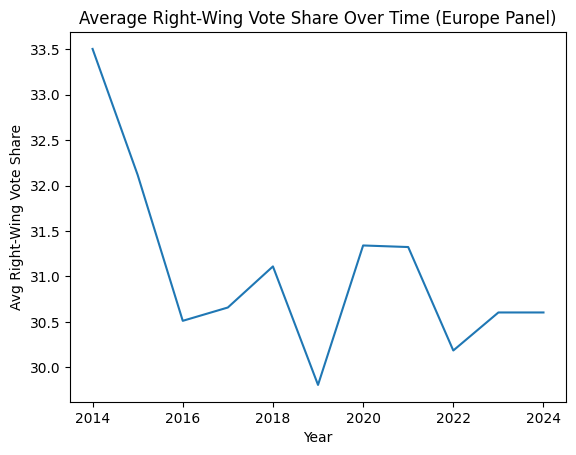

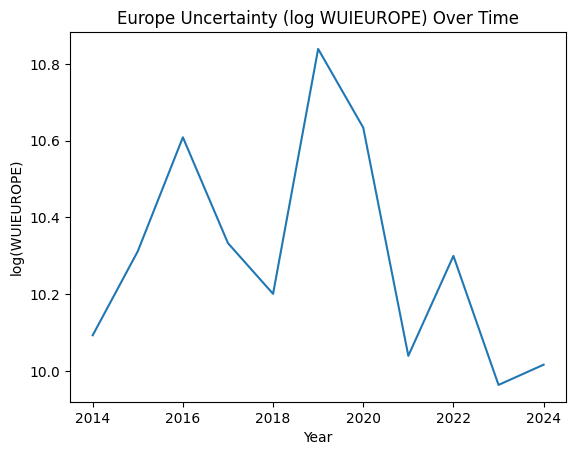

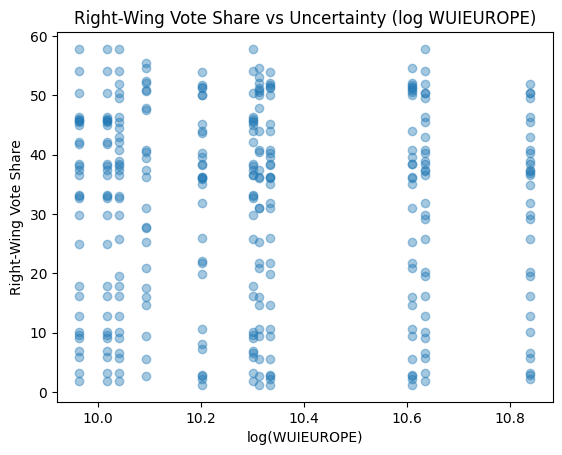

Correlation(log_wui, right_wing_vote_share) = -0.0192


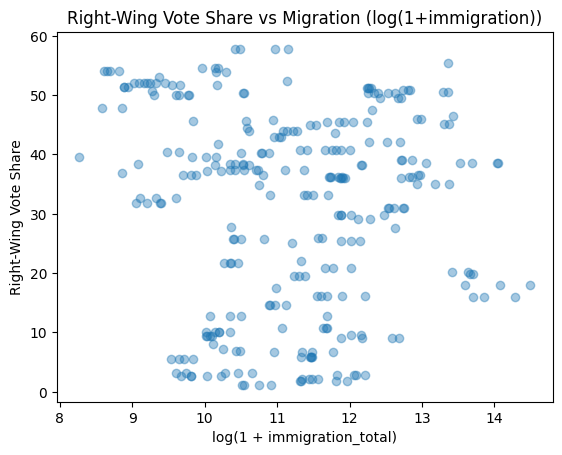

Correlation(log_immigration_total, right_wing_vote_share) = -0.062


In [9]:
# -------------------------
# STEP 5: EDA
# -------------------------
yearly_avg = (
    df_final.groupby("year", as_index=False)
            .agg(avg_right_wing=("right_wing_vote_share", "mean"),
                 avg_log_wui=("log_wui", "mean"),
                 avg_log_imm=("log_immigration_total", "mean"))
)

display(yearly_avg)

plt.plot(yearly_avg["year"], yearly_avg["avg_right_wing"])
plt.title("Average Right-Wing Vote Share Over Time (Europe Panel)")
plt.xlabel("Year")
plt.ylabel("Avg Right-Wing Vote Share")
plt.show()

plt.plot(yearly_avg["year"], yearly_avg["avg_log_wui"])
plt.title("Europe Uncertainty (log WUIEUROPE) Over Time")
plt.xlabel("Year")
plt.ylabel("log(WUIEUROPE)")
plt.show()

plt.scatter(df_final["log_wui"], df_final["right_wing_vote_share"], alpha=0.4)
plt.title("Right-Wing Vote Share vs Uncertainty (log WUIEUROPE)")
plt.xlabel("log(WUIEUROPE)")
plt.ylabel("Right-Wing Vote Share")
plt.show()

corr = df_final["log_wui"].corr(df_final["right_wing_vote_share"])
print("Correlation(log_wui, right_wing_vote_share) =", round(corr, 4))


tmp = df_final.dropna(subset=["log_immigration_total"]).copy()
plt.scatter(tmp["log_immigration_total"], tmp["right_wing_vote_share"], alpha=0.4)
plt.title("Right-Wing Vote Share vs Migration (log(1+immigration))")
plt.xlabel("log(1 + immigration_total)")
plt.ylabel("Right-Wing Vote Share")
plt.show()

corr_m = tmp["log_immigration_total"].corr(tmp["right_wing_vote_share"])
print("Correlation(log_immigration_total, right_wing_vote_share) =", round(corr_m, 4))

In [11]:

from scipy import stats

print(">>> HYPOTHESIS TEST RESULTS <<<\n")

median_wui = df_final["log_wui"].median()

high = df_final[df_final["log_wui"] >= median_wui]["right_wing_vote_share"].dropna()
low  = df_final[df_final["log_wui"] <  median_wui]["right_wing_vote_share"].dropna()

t_stat, p_val = stats.ttest_ind(high, low, equal_var=False)

print("--- [H1] Uncertainty vs Right-Wing Vote Share (High vs Low log_wui) ---")
print("Mean (High WUI):", round(high.mean(), 3))
print("Mean (Low  WUI):", round(low.mean(), 3))
print("t-stat:", round(t_stat, 3), "| p-value:", round(p_val, 5))

if p_val < 0.05:
    print(">> RESULT: Supported (statistically significant difference).")
else:
    print(">> RESULT: Not supported (no significant difference).")


>>> HYPOTHESIS TEST RESULTS <<<

--- [H1] Uncertainty vs Right-Wing Vote Share (High vs Low log_wui) ---
Mean (High WUI): 30.74
Mean (Low  WUI): 31.342
t-stat: -0.318 | p-value: 0.75075
>> RESULT: Not supported (no significant difference).
